### 주제: 건설 장비 내부 기계 부품의 마모 상태 및 윤활 성능을 오일 데이터 분석을 통해 확인하고, AI를 활용한 분류 모델 개발을 통해 적절한 교체 주기를 파악

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew, ttest_ind, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFECV

데이터 분석 목표: 샘플 오일 관련 부품 정보를 분석해 오일 정상 여부 예측

In [22]:
train = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/train.csv')
test_df = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/test.csv')
submission = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/sample_submission.csv')

In [23]:
test_df.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

In [24]:
columns = ['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN','Y_LABEL']

변수 정보   
ANONYMOUS_1 - 무명 Feature 1. 수치형 데이터   
ANONYMOUS_2 - 무명 Feature 2. 수치형 데이터   
AG, CO, CR, FE, H2O, MN, MO, NI, TI, V, ZN - 원소기호   
V40 - 40도에서 측정한 액체의 점도   
YEAR - 오일샘플 및 진단 해(Year)    
PQINDEX(Particle Quantifier Index) : Particle Quantifier Index(PQ Index), 또는 PQI라고도 불리는 이 지표는 입자의 크기와 상관없이 윤활유 샘플 내에 존재하는 전체 강자성 물질(자성을 띤 금속 입자)의 양을 측정하는 방법이다.
이 지표는 마모로 인한 문제가 발생할 가능성을 조기에 감지하기 위한 선별 검사 도구로 사용되며, 예지 보전(predictive maintenance) 프로그램에서 자주 활용된다.    

Y_LABEL - 타깃변수로 0일 때 정상, 1일 때 비정상


train 데이터에는 존재하나 test 데이터에는 없는 변수들 존재했었다. 이는 모델 학습 시 사용할 수 없는 변수들이기 때문에 제거해주었다.    

In [25]:
train_df = train[columns]

In [26]:
train_df['COMPONENT_ARBITRARY'].value_counts()

COMPONENT_ARBITRARY
COMPONENT3    7050
COMPONENT1    3890
COMPONENT2    2316
COMPONENT4     839
Name: count, dtype: int64

부품 종류로는 4개가 있으며 1은 3890개, 2는 2316개, 3은 7050개, 4는 839개씩 있다.    

In [27]:
# COMPONENT_ARBITRARY별 Y_LABEL의 0,1 개수
count = train_df.groupby('COMPONENT_ARBITRARY')['Y_LABEL'].value_counts().unstack().fillna(0)
print("개수:\n", count)

# COMPONENT_ARBITRARY별 Y_LABEL의 0,1 비율
ratio = train_df.groupby('COMPONENT_ARBITRARY')['Y_LABEL'].value_counts(normalize=True).unstack().fillna(0)
print("\n비율:\n", ratio)

개수:
 Y_LABEL                 0     1
COMPONENT_ARBITRARY            
COMPONENT1           3500   390
COMPONENT2           1915   401
COMPONENT3           4906  2144
COMPONENT4            750    89

비율:
 Y_LABEL                     0         1
COMPONENT_ARBITRARY                    
COMPONENT1           0.899743  0.100257
COMPONENT2           0.826857  0.173143
COMPONENT3           0.695887  0.304113
COMPONENT4           0.893921  0.106079


COMPONENT_ARBITRARY별로 오일 정상, 비정상 개수 및 비율을 확인해본 결과 COMPONENT 2와 3에서 이상 오일 비율이 높게 나온 것을 확인할 수 있었다.    
이상 샘플이 Component 3에서 차지하는 비율이 0.3으로 다른 Component에 비해 높게 나온 것을 확인

In [28]:
# YEAR별 Y_LABEL의 0,1 개수
count = train_df.groupby('YEAR')['Y_LABEL'].value_counts().unstack().fillna(0)
print("개수:\n", count)

# YEAR별 Y_LABEL의 0,1 비율
ratio = train_df.groupby('YEAR')['Y_LABEL'].value_counts(normalize=True).unstack().fillna(0)
print("\n비율:\n", ratio)

개수:
 Y_LABEL     0    1
YEAR              
2007      236   92
2008     1062  357
2009      681  268
2010      639  227
2011      910  236
2012      849  224
2013      949  240
2014     1133  267
2015      935  221
2016      771  171
2017      740  156
2018      699  179
2019      520  129
2020      275   98
2021      381   96
2022      291   63

비율:
 Y_LABEL         0         1
YEAR                       
2007     0.719512  0.280488
2008     0.748414  0.251586
2009     0.717597  0.282403
2010     0.737875  0.262125
2011     0.794066  0.205934
2012     0.791240  0.208760
2013     0.798150  0.201850
2014     0.809286  0.190714
2015     0.808824  0.191176
2016     0.818471  0.181529
2017     0.825893  0.174107
2018     0.796128  0.203872
2019     0.801233  0.198767
2020     0.737265  0.262735
2021     0.798742  0.201258
2022     0.822034  0.177966


YEAR별로 오일 정상, 비정상 개수 및 비율을 확인해본 결과 특정 연도에서 비정상 비율이 높게 나온 것을 확인할 수 있었다

In [29]:
train_df.groupby('COMPONENT_ARBITRARY').mean(numeric_only=True)

# 평균값을 표로 보기 좋게 출력
mean_df = train_df.groupby('COMPONENT_ARBITRARY').mean(numeric_only=True)
display(mean_df)

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
COMPONENT_ARBITRARY,,,,,,,,,,,,,,,,,,
COMPONENT1,-0.986054,2013.729563,-0.959173,0.025193,0.014396,1.910540,9.929563,27.057069,0.002699,0.514910,69.364267,0.152185,20.422622,0.055013,0.024422,102.678103,1161.010283,0.100257
COMPONENT2,-0.986206,2013.718912,-0.961256,0.024180,0.009499,0.515976,56.677029,18.890328,0.003282,0.155872,0.652418,0.027634,27.230570,0.032815,0.010794,52.720695,505.785838,0.173143
COMPONENT3,-0.984818,2013.494043,-0.961531,0.028227,0.044397,5.361986,32.252057,332.500426,0.064525,5.137163,3.415745,1.362553,807.300567,1.372908,0.082837,136.411370,241.379574,0.304113
COMPONENT4,-0.984588,2014.443385,-0.953130,0.013111,0.007151,0.091776,107.109654,21.651967,0.001549,0.852205,50.958284,0.034565,21.091776,0.010727,0.011919,69.310012,1081.669845,0.106079


ANONYMOUS_1 과 ANONYMOUS_2는 더해서 하나의 변수로 만들어주었다.

In [30]:
# ANONYMOUS_1 과 ANONYMOUS_2 더해서 새로운 피처 생성
train_df['ANONYMOUS_SUM'] = train_df['ANONYMOUS_1'] + train_df['ANONYMOUS_2']

# ANONYMOUS_1, ANONYMOUS_2 제거
train_df = train_df.drop(columns=['ANONYMOUS_1', 'ANONYMOUS_2'])

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_400\1612360360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ANONYMOUS_SUM'] = train_df['ANONYMOUS_1'] + train_df['ANONYMOUS_2']


In [31]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats = train_df.groupby(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']).median(numeric_only=True)
grouped_stats

AG   CO   CR    CU    FE  H2O   MN     MO  \
COMPONENT_ARBITRARY YEAR Y_LABEL                                               
COMPONENT1          2007 0        0.0  0.0  2.0   3.0  23.5  0.0  1.0   21.0   
                         1        0.0  0.0  3.0  22.0  47.0  0.0  1.0  104.0   
                    2008 0        0.0  0.0  1.0   4.0  21.0  0.0  1.0   37.0   
                         1        0.0  0.0  4.0   9.0  51.5  0.0  1.0   99.0   
                    2009 0        0.0  0.0  2.0   4.0  24.0  0.0  1.0   37.0   
...                               ...  ...  ...   ...   ...  ...  ...    ...   
COMPONENT4          2020 1        0.0  0.0  0.0  17.5  44.0  0.0  1.5   22.0   
                    2021 0        0.0  0.0  0.0   0.0  11.0  0.0  0.0    2.0   
                         1        0.0  0.0  0.0   5.5  54.5  0.0  0.0    5.5   
                    2022 0        0.0  0.0  0.0   1.0  11.0  0.0  0.0   20.0   
                         1        0.0  0.0  0.0   1.0  11.0  0.0  0.0   25.0   

                                   NI  PQINDEX   TI    V     V40      ZN  \
COMPONENT_ARBITRARY YEAR Y_LABEL                                           
COMPONENT1          2007 0        0.0     17.0  0.0  0.0  101.30  1208.5   
                         1        0.0     18.0  0.0  0.0  112.60  1280.0   
                    2008 0        0.0     14.0  0.0  0.0  105.30  1225.0   
                         1        1.0     17.0  0.0  0.0  109.25  1278.0   
                    2009 0        0.0     12.0  0.0  0.0  103.20  1183.0   
...                               ...      ...  ...  ...     ...     ...   
COMPONENT4          2020 1        0.0     48.0  0.0  0.0   53.35   480.5   
                    2021 0        0.0     11.0  0.0  0.0   71.40  1038.0   
                         1        0.0     25.0  0.0  0.0   64.00  1109.0   
                    2022 0        0.0      8.0  0.0  0.0   70.40  1077.0   
                         1        0.0     10.0  0.0  0.0   59.80  1162.0   

                                  ANONYMOUS_SUM  
COMPONENT_ARBITRARY YEAR Y_LABEL                 
COMPONENT1          2007 0            -1.953617  
                         1            -1.960353  
                    2008 0            -1.958369  
                         1            -1.928166  
                    2009 0            -1.988598  
...                                         ...  
COMPONENT4          2020 1            -1.958085  
                    2021 0            -1.904710  
                         1            -1.977001  
                    2022 0            -1.912576  
                         1            -1.894914  

[127 rows x 15 columns]

In [32]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats2 = train_df.groupby(['COMPONENT_ARBITRARY','Y_LABEL']).mean(numeric_only=True)
grouped_stats2

YEAR        AG        CO         CR  \
COMPONENT_ARBITRARY Y_LABEL                                               
COMPONENT1          0        2013.795429  0.023143  0.014571   1.378000   
                    1        2013.138462  0.043590  0.012821   6.689744   
COMPONENT2          0        2013.817755  0.025587  0.007833   0.401044   
                    1        2013.246883  0.017456  0.017456   1.064838   
COMPONENT3          0        2013.614757  0.024868  0.023848   1.779250   
                    1        2013.217817  0.035914  0.091418  13.560168   
COMPONENT4          0        2014.441333  0.013333  0.004000   0.076000   
                    1        2014.460674  0.011236  0.033708   0.224719   

                                     CU          FE       H2O         MN  \
COMPONENT_ARBITRARY Y_LABEL                                                
COMPONENT1          0          8.921714   22.762571  0.001571   0.450571   
                    1         18.974359   65.597436  0.012821   1.092308   
COMPONENT2          0         52.925849   13.013055  0.001097   0.096606   
                    1         74.591022   46.957606  0.013716   0.438903   
COMPONENT3          0         19.878516  156.025275  0.004260   2.804525   
                    1         60.565765  736.319030  0.202425  10.474813   
COMPONENT4          0        107.133333   19.585333  0.001200   0.644000   
                    1        106.910112   39.067416  0.004494   2.606742   

                                    MO        NI      PQINDEX        TI  \
COMPONENT_ARBITRARY Y_LABEL                                               
COMPONENT1          0        69.089429  0.102286    12.703143  0.020571   
                    1        71.830769  0.600000    89.700000  0.364103   
COMPONENT2          0         0.572324  0.023499    13.025065  0.021932   
                    1         1.034913  0.047382    95.069825  0.084788   
COMPONENT3          0         2.704240  0.622503   316.359967  0.135956   
                    1         5.043843  3.055970  1930.693563  4.203358   
COMPONENT4          0        52.713333  0.034667    16.044000  0.009333   
                    1        36.168539  0.033708    63.629213  0.022472   

                                    V         V40           ZN  ANONYMOUS_SUM  
COMPONENT_ARBITRARY Y_LABEL                                                    
COMPONENT1          0        0.021429  102.497291  1160.656571      -1.945416  
                    1        0.051282  104.300769  1164.184615      -1.943537  
COMPONENT2          0        0.012533   52.290501   518.969191      -1.946706  
                    1        0.002494   54.775112   442.827930      -1.951072  
COMPONENT3          0        0.023848  134.057440   260.599674      -1.946695  
                    1        0.217817  141.797743   197.399254      -1.945556  
COMPONENT4          0        0.013333   69.785867  1096.238667      -1.938453  
                    1        0.000000   65.300000   958.898876      -1.931529

In [33]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats3 = train_df.groupby(['COMPONENT_ARBITRARY','Y_LABEL']).median(numeric_only=True)
grouped_stats3

YEAR   AG   CO   CR    CU     FE  H2O   MN  \
COMPONENT_ARBITRARY Y_LABEL                                                 
COMPONENT1          0        2014.0  0.0  0.0  1.0   3.0   18.0  0.0  0.0   
                    1        2013.0  0.0  0.0  3.0   7.0   43.5  0.0  1.0   
COMPONENT2          0        2014.0  0.0  0.0  0.0  11.0    5.0  0.0  0.0   
                    1        2013.0  0.0  0.0  0.0  21.0   14.0  0.0  0.0   
COMPONENT3          0        2014.0  0.0  0.0  1.0   4.0   96.0  0.0  1.0   
                    1        2013.0  0.0  0.0  4.0   5.0  379.0  0.0  5.0   
COMPONENT4          0        2014.0  0.0  0.0  0.0   5.0   16.0  0.0  0.0   
                    1        2014.0  0.0  0.0  0.0  21.0   23.0  0.0  0.0   

                               MO   NI  PQINDEX   TI    V     V40      ZN  \
COMPONENT_ARBITRARY Y_LABEL                                                 
COMPONENT1          0        20.0  0.0     11.0  0.0  0.0  100.50  1148.0   
                    1        34.0  0.0     17.0  0.0  0.0  102.95  1170.5   
COMPONENT2          0         0.0  0.0     11.0  0.0  0.0   47.10   566.0   
                    1         0.0  0.0     30.0  0.0  0.0   53.00   445.0   
COMPONENT3          0         0.0  0.0    106.0  0.0  0.0  136.50    38.0   
                    1         1.0  1.0    744.0  0.0  0.0  138.40    38.0   
COMPONENT4          0        10.5  0.0     15.0  0.0  0.0   70.65  1131.0   
                    1         8.0  0.0     25.0  0.0  0.0   68.20  1107.0   

                             ANONYMOUS_SUM  
COMPONENT_ARBITRARY Y_LABEL                 
COMPONENT1          0            -1.979308  
                    1            -1.978154  
COMPONENT2          0            -1.978818  
                    1            -1.982075  
COMPONENT3          0            -1.976357  
                    1            -1.975860  
COMPONENT4          0            -1.977908  
                    1            -1.972581

변수들간의 수치를 직접 비교하기 위해서 스케일링을 적용시켰다

In [34]:
# 스케일링 대상 수치형 변수 리스트 (ID, COMPONENT_ARBITRARY, Y_LABEL 제외)
num_cols = [col for col in train_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL', 'YEAR']]

scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[num_cols] = scaler.fit_transform(train_df[num_cols])

display(train_df_scaled.head())

,ID,COMPONENT_ARBITRARY,YEAR,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL,ANONYMOUS_SUM
0,TRAIN_00000,COMPONENT3,2011,-0.150214,-0.089633,0.339245,0.336858,1.331290,-0.041588,1.186914,-0.384284,1.384414,5.293270,0.622282,-0.10655,0.899892,-0.966002,1,-0.418234
1,TRAIN_00001,COMPONENT2,2021,-0.150214,-0.089633,-0.115388,-0.027612,-0.330406,-0.041588,-0.250456,-0.400998,-0.191804,-0.259244,-0.102635,-0.10655,-1.317376,0.119147,0,-0.121986
2,TRAIN_00002,COMPONENT2,2015,-0.150214,-0.089633,-0.080416,-0.252497,-0.326655,-0.041588,-0.250456,-0.400998,-0.191804,-0.260552,-0.102635,-0.10655,-0.740886,-0.332215,0,-0.366290
3,TRAIN_00003,COMPONENT3,2010,-0.150214,-0.089633,-0.115388,-0.260252,-0.264764,-0.041588,-0.160621,-0.400998,-0.191804,-0.242884,-0.102635,-0.10655,0.482642,-1.093888,0,-0.088173
4,TRAIN_00004,COMPONENT3,2015,-0.150214,-0.089633,-0.115388,-0.268007,-0.200996,-0.041588,-0.250456,-0.400998,-0.191804,-0.129674,-0.102635,-0.10655,0.478611,-0.866326,0,-0.280238


## Optuna 튜닝용 모델 학습 함수

In [35]:
# Optuna 튜닝용 objective 함수 예시 (각 모델별)

# random forest
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# gradient boosting
def gb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'random_state': 42
    }
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# lightgbm
def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# extra trees
def extratrees_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# catboost
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# adaboost
def adaboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        'random_state': 42
    }
    model = AdaBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# xgboost
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

Component에 따라서 변수의 수치가 크게 달라졌기 때문에 각 Component 별로 그룹화해서 보는 것이 비정상, 정상 데이터 간 차이를 명확하게 볼 수 있다고 판단했다   

## Component 4

In [36]:
comp_4 = train_df_scaled[train_df_scaled['COMPONENT_ARBITRARY'] == 'COMPONENT4']

In [37]:
# Y_LABEL이 0과 1인 데이터 각각 추출
comp4_0 = comp_4[comp_4['Y_LABEL'] == 0]
comp4_1 = comp_4[comp_4['Y_LABEL'] == 1]

# 주요 변수별 평균 비교
mean_0 = comp4_0.mean(numeric_only=True)
mean_1 = comp4_1.mean(numeric_only=True)
diff = pd.DataFrame({'Y_LABEL=0': mean_0, 'Y_LABEL=1': mean_1})

display(diff)

# 주요 변수별 중앙값 비교
median_0 = comp4_0.median(numeric_only=True)
median_1 = comp4_1.median(numeric_only=True)
median_diff = pd.DataFrame({'Y_LABEL=0': median_0, 'Y_LABEL=1': median_1})

display(median_diff)

,Y_LABEL=0,Y_LABEL=1
YEAR,2014.441333,2014.460674
AG,-0.072658,-0.084858
CO,-0.076904,0.017636
CR,-0.112730,-0.107529
CU,0.562778,0.561047
FE,-0.297425,-0.260886
H2O,-0.040105,-0.036033
MN,-0.192602,-0.016278
MO,0.480028,0.203506
NI,-0.182697,-0.182949


,Y_LABEL=0,Y_LABEL=1
YEAR,2014.000000,2014.000000
AG,-0.150214,-0.150214
CO,-0.089633,-0.089633
CR,-0.115388,-0.115388
CU,-0.229233,-0.105158
FE,-0.304149,-0.291021
H2O,-0.041588,-0.041588
MN,-0.250456,-0.250456
MO,-0.225506,-0.267289
NI,-0.191804,-0.191804


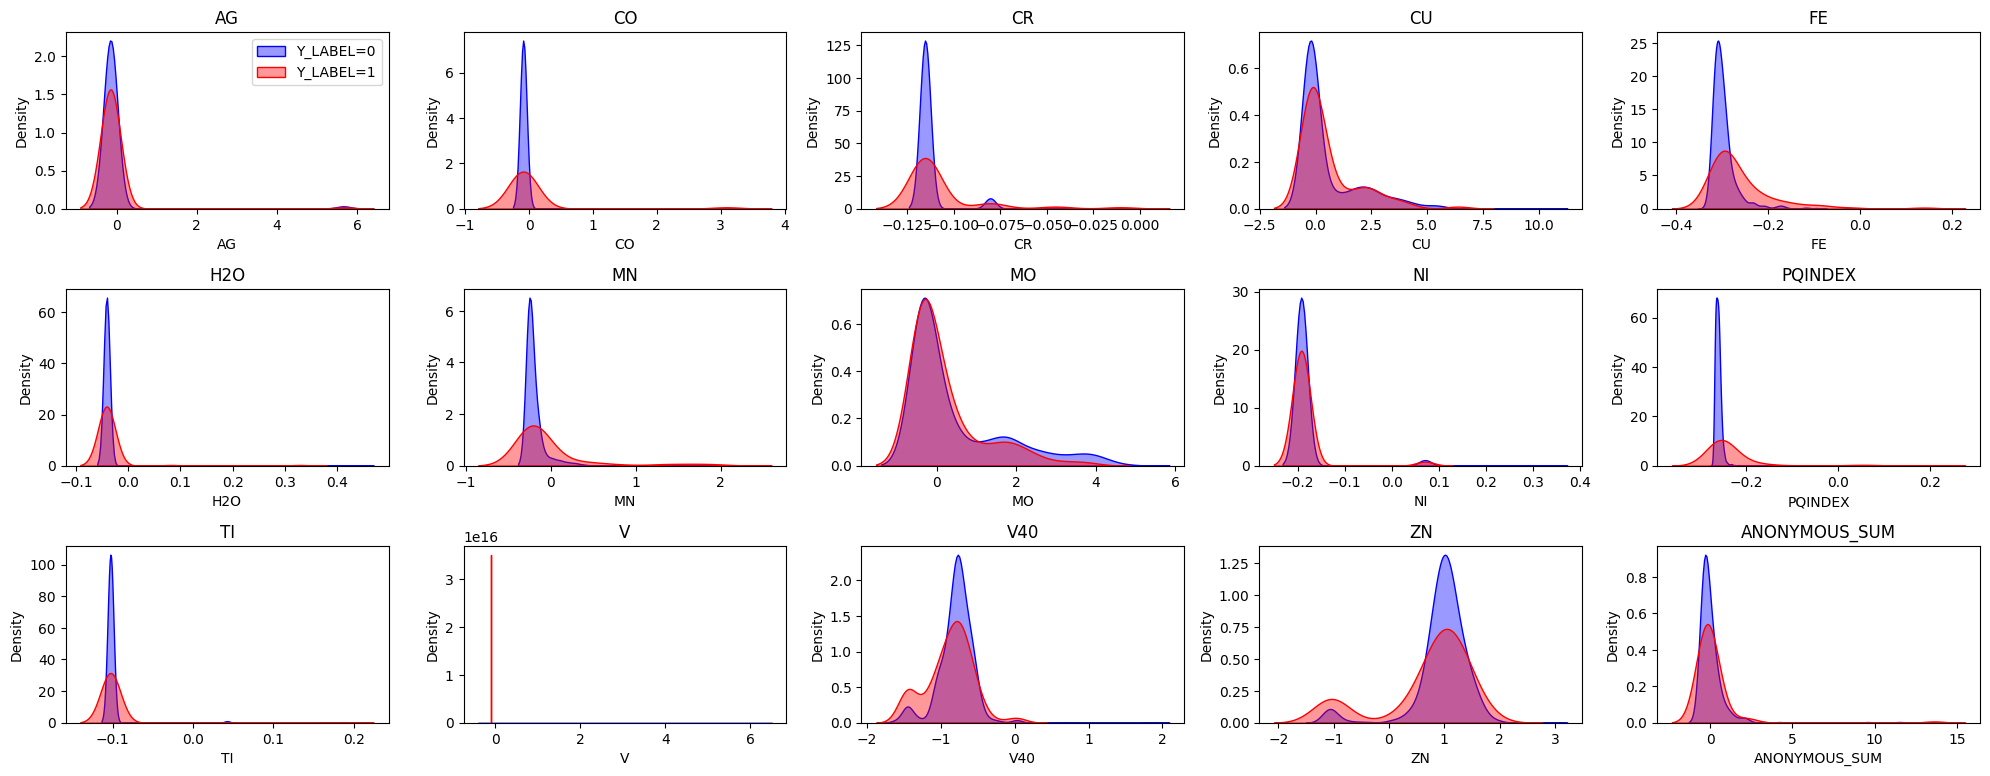

In [38]:
plt.figure(figsize=(20, 10))
for var in num_cols:
  plt.subplot(4, 5, num_cols.index(var)+1)
  sns.kdeplot(comp4_0[var], label='Y_LABEL=0', color='blue', fill=True, alpha=0.4)
  sns.kdeplot(comp4_1[var], label='Y_LABEL=1', color='red', fill=True, alpha=0.4)
  plt.title(var)
  plt.xlabel(var)
  plt.ylabel('Density')
  if num_cols.index(var) == 0:
    plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# 주요 변수별 첨도(kurtosis)와 왜도(skewness) 계산
# independent_vars 정의 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in train_df_scaled.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL']]

kurt_skew = []
for col in independent_vars:
  kurt_0 = kurtosis(comp4_0[col], nan_policy='omit')
  skew_0 = skew(comp4_0[col], nan_policy='omit')
  kurt_1 = kurtosis(comp4_1[col], nan_policy='omit')
  skew_1 = skew(comp4_1[col], nan_policy='omit')
  kurt_skew.append({
    '변수': col,
    'Y_LABEL=0_첨도': kurt_0,
    'Y_LABEL=0_왜도': skew_0,
    'Y_LABEL=1_첨도': kurt_1,
    'Y_LABEL=1_왜도': skew_1
  })

kurt_skew_df = pd.DataFrame(kurt_skew)
display(kurt_skew_df)

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_400\782037066.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_1 = kurtosis(comp4_1[col], nan_policy='omit')
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_400\782037066.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_1 = skew(comp4_1[col], nan_policy='omit')


,변수,Y_LABEL=0_첨도,Y_LABEL=0_왜도,Y_LABEL=1_첨도,Y_LABEL=1_왜도
0,YEAR,-0.998638,0.020938,-1.235533,0.006756
1,AG,70.013514,8.486078,84.011364,9.274231
2,CO,245.004016,15.716361,24.701550,5.167354
3,CR,30.004171,4.955996,9.013008,3.035406
4,CU,4.687992,2.030672,4.012416,1.994896
5,FE,13.909275,3.128879,9.754991,2.758647
6,H2O,342.135796,17.663937,68.141811,8.175245
7,MN,103.725095,8.413304,6.647936,2.722106
8,MO,1.200580,1.494700,2.766770,1.832060
9,NI,33.524048,5.659195,24.701550,5.167354


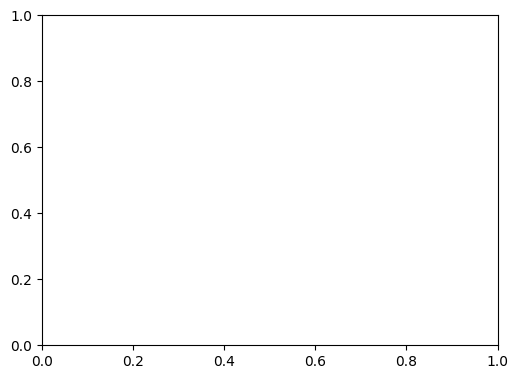

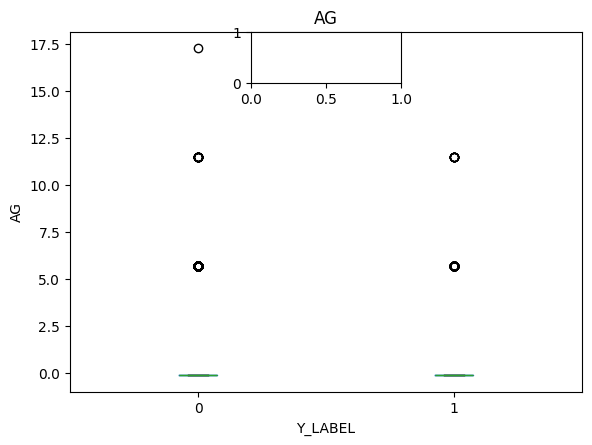

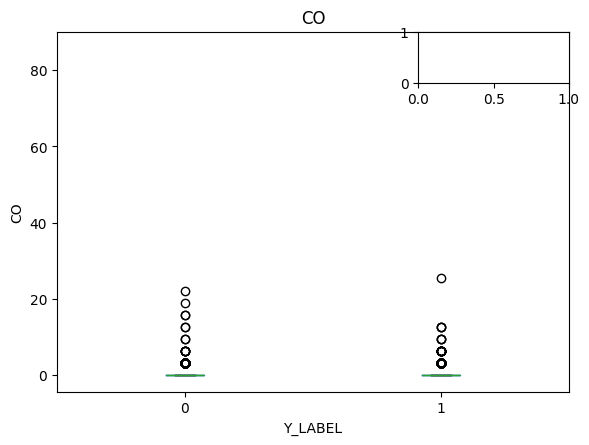

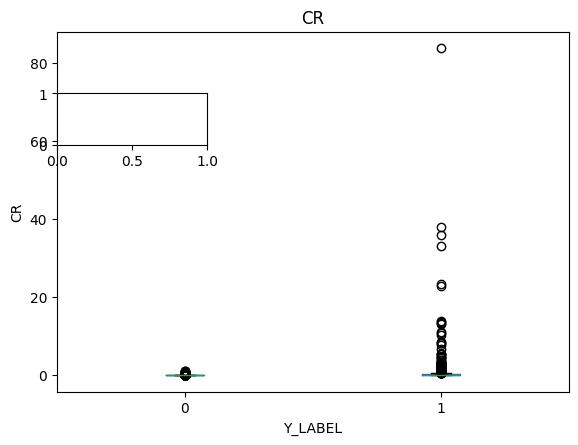

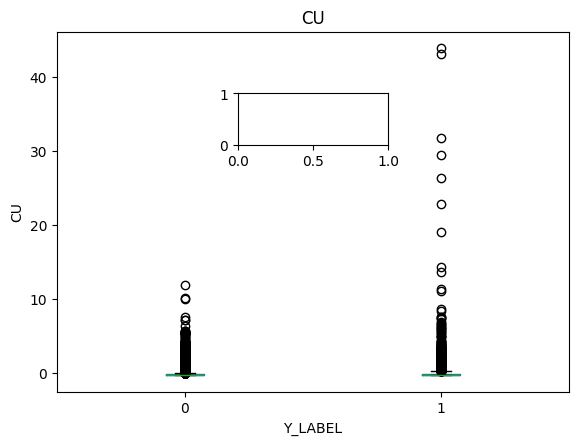

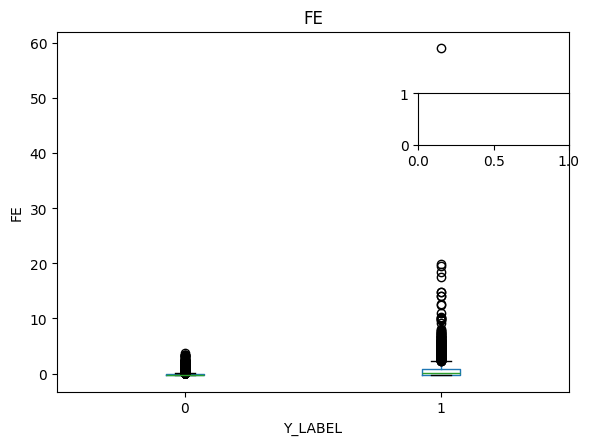

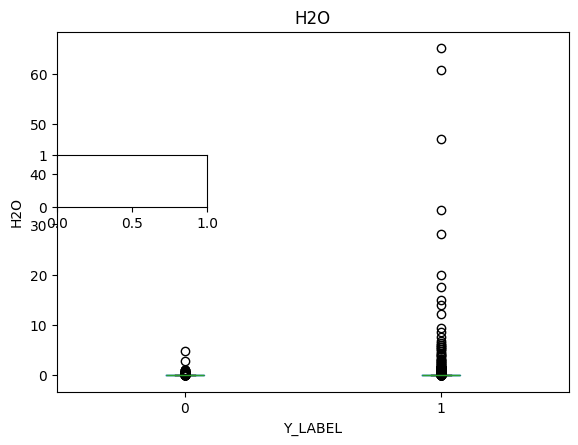

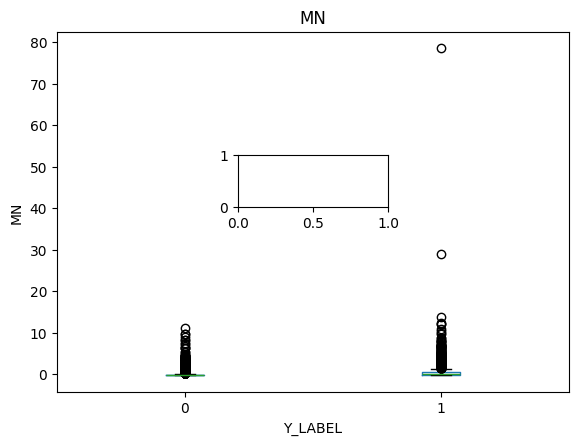

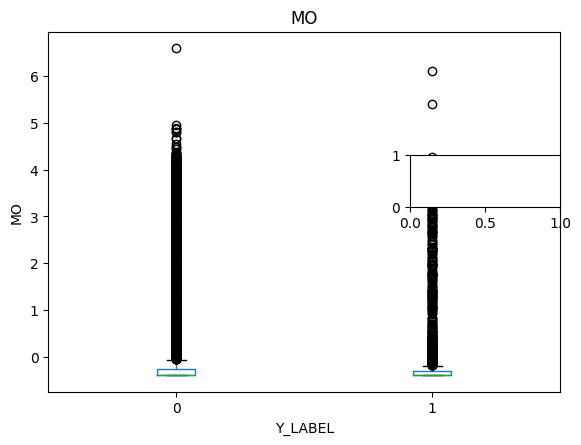

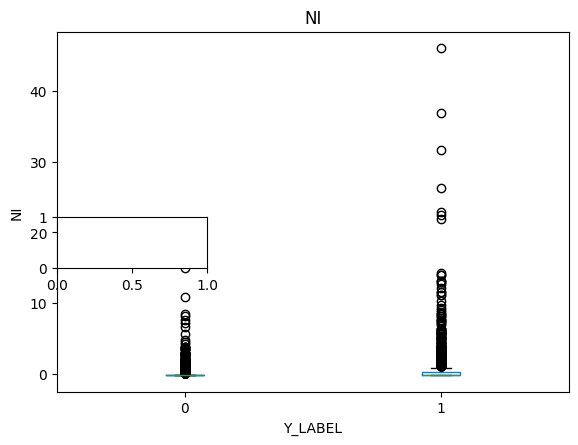

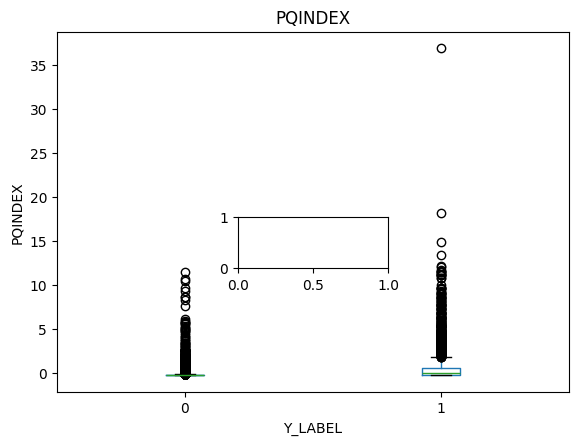

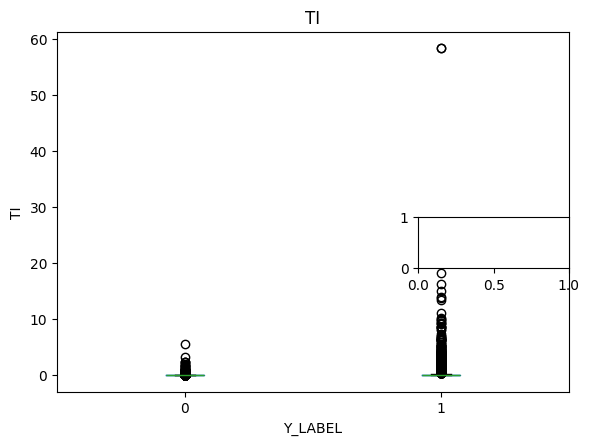

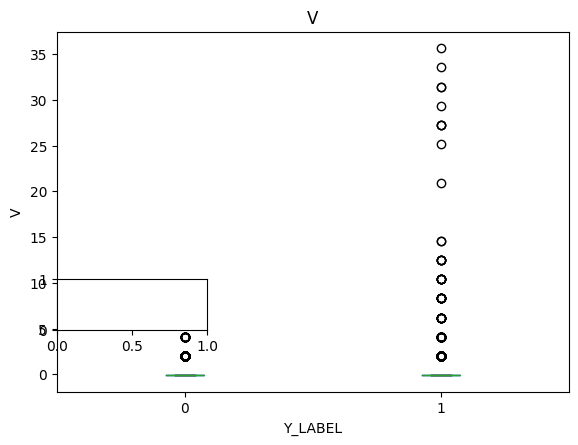

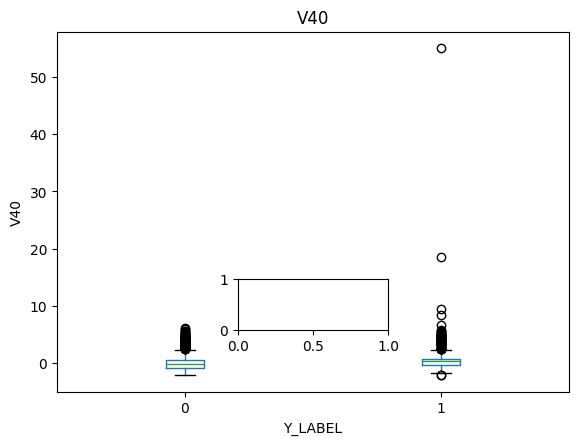

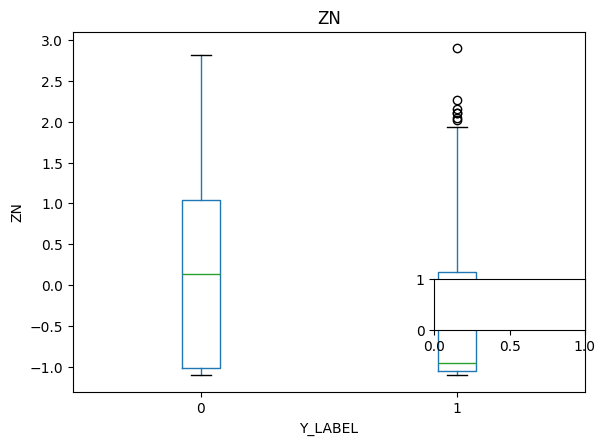

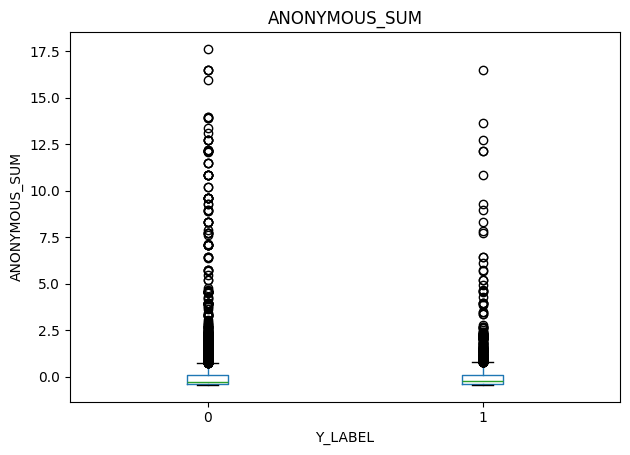

In [40]:
# 변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY, YEAR 제외)
plot_vars = [col for col in train_df_scaled.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR','Y_LABEL']]

plt.figure(figsize=(20, 30))
for i, var in enumerate(plot_vars):
  plt.subplot(6, 3, i+1)
  train_df_scaled.boxplot(column=var, by='Y_LABEL', grid=False)
  plt.title(var)
  plt.suptitle('')
  plt.xlabel('Y_LABEL')
  plt.ylabel(var)
plt.tight_layout()
plt.show()

In [41]:
# COMPONENT1 데이터에서 독립변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in comp_4.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

# 결과 저장용
test_results = []

for col in independent_vars:
    # 두 그룹 데이터
    group0 = comp4_0[col]
    group1 = comp4_1[col]
    # 정규성, 등분산성 가정이 어려우므로 Mann-Whitney U test 사용
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    # p-value를 소수점 5자리까지만 표시
    p_rounded = round(p, 5)
    test_results.append({'변수': col, 'Mann-Whitney U 통계량': stat, 'p-value': p_rounded})

# 결과 DataFrame으로 정리
test = pd.DataFrame(test_results)
display(test.sort_values('p-value'))

,변수,Mann-Whitney U 통계량,p-value
4,FE,19492.0,0.00000
9,PQINDEX,17072.5,0.00000
6,MN,25907.5,0.00002
1,CO,32383.5,0.00168
3,CU,26702.0,0.00194
2,CR,30596.0,0.00457
12,V40,39179.5,0.00725
13,ZN,37522.0,0.05508
5,H2O,32803.5,0.07031
7,MO,36728.5,0.11932


유의미한 변수 (p-value ≤ 0.05)    
FE, PQINDEX, MN, CO, CU, CR, V40    
이 변수들은 정상/비정상 그룹 간 분포 차이가 유의미합니다.   
특히 FE, PQINDEX, MN은 p-value가 매우 작아 차이가 큽니다.   
CO, CU, CR, V40도 0.05 이하로 유의미합니다.   

유의미하지 않은 변수 (p-value > 0.05)   
ZN, H2O, MO, V, ANONYMOUS_SUM, TI, AG, NI   
이 변수들은 정상/비정상 그룹 간 분포 차이가 통계적으로 유의하지 않습니다.   
즉, 이 변수들은 Y_LABEL 분류에 큰 영향을 주지 않을 수 있습니다..    

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Progr

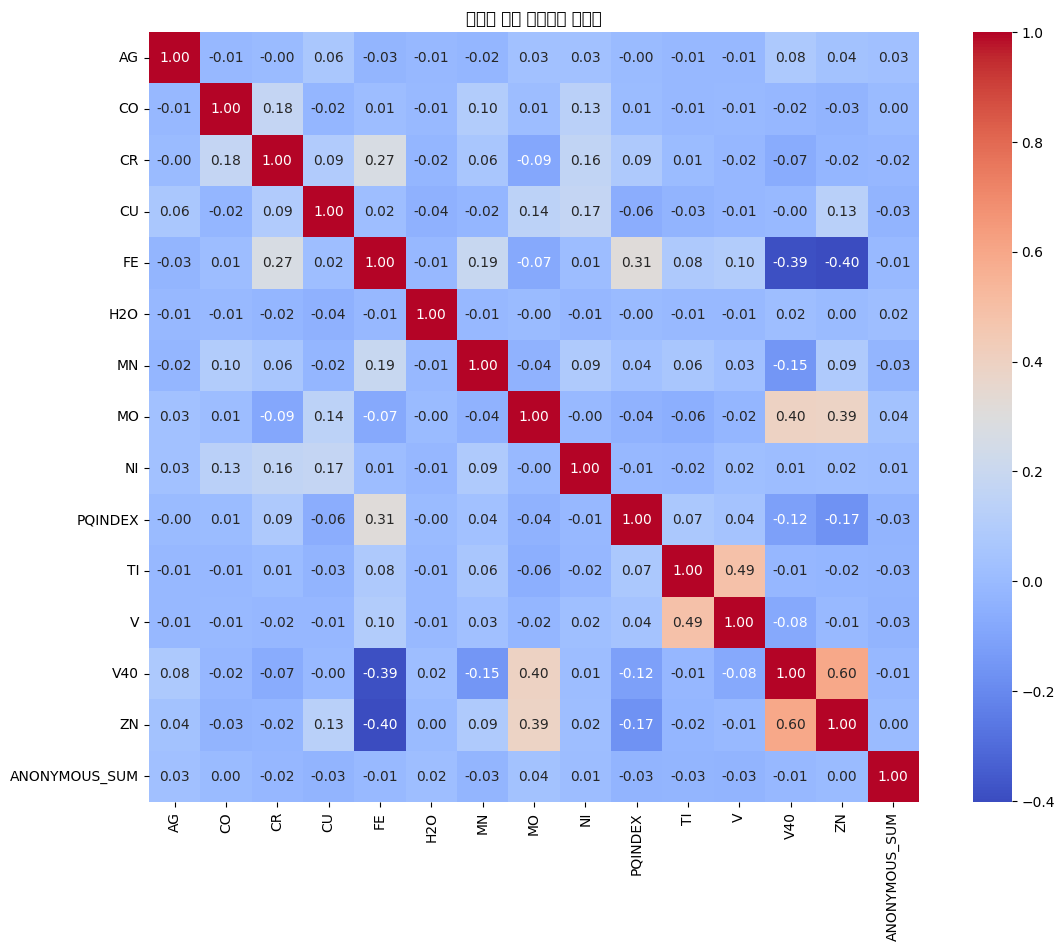

In [43]:
# 수치형 변수만 추출 (ID, COMPONENT_ARBITRARY, YEAR, Y_LABEL 등 제외)
numeric_cols = [col for col in train_df_scaled.columns if train_df_scaled[col].dtype != 'O' and col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

# 수치형 변수만 남긴 데이터프레임
numeric_df = comp_4[numeric_cols]

# 상관관계 분석
plt.figure(figsize=(14, 10))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("수치형 변수 상관관계 히트맵")
plt.show()

변수들 간의 상관계수를 확인한 결과 상관성이 높게 나오지는 않았다.

### 모델링

In [44]:
# 범주형 변수는 원-핫 인코딩처리
comp4_df = pd.get_dummies(comp_4, columns=['YEAR'], prefix='YEAR')

In [45]:
# X, y 분리 (ID, COMPONENT_ARBITRARY, Y_LABEL은 제외)
X = comp4_df.drop(columns=['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL'])
y = comp4_df['Y_LABEL']

# train, test 데이터 분할 (예: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 분할된 데이터 shape 확인
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (671, 31) (671,)
Test shape: (168, 31) (168,)


In [46]:
# 여러 모델 정의
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=300, random_state=42),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=300, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=300, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=300, random_state=42),
    'CatBoost': CatBoostClassifier(iterations=300, random_state=42, verbose=0)
}

results = []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

  results.append({
    'Model': name,
    'Accuracy': acc,
    'F1 Score': f1,
    'ROC AUC': auc
  })

results_df = pd.DataFrame(results)
display(results_df.sort_values('F1 Score', ascending=False))

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 71, number of negative: 600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 671, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.105812 -> initscore=-2.134250
[LightGBM] [Info] Start training from score -2.134250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Model,Accuracy,F1 Score,ROC AUC
2,GradientBoosting,0.916667,0.416667,0.735185
6,LightGBM,0.898810,0.370370,0.753704
5,XGBoost,0.904762,0.272727,0.723704
4,AdaBoost,0.880952,0.230769,0.611852
0,LogisticRegression,0.904762,0.200000,0.635556
7,CatBoost,0.904762,0.200000,0.792963
1,RandomForest,0.892857,0.181818,0.813519
3,ExtraTrees,0.898810,0.105263,0.813889


Component4를 넣고 모델링을 했을 시에는 GradientBoosting의 성능이 가장 높게 나왔다.

In [47]:
def optuna_model_train_eval(objective_func, model_class, X_train, X_test, y_train, y_test, n_trials=50, random_state=42, model_name="Model"):
    # Optuna 스터디 생성 및 최적화 실행
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=n_trials, show_progress_bar=True)

    print(f"Best parameters ({model_name}):", study.best_params)
    print(f"Best F1 score (CV, {model_name}):", study.best_value)

    # 최적 파라미터로 모델 학습 및 테스트셋 평가
    best_model = model_class(**study.best_params, random_state=random_state)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Test Accuracy ({model_name}): {acc:.4f}")
    print(f"Test F1 Score ({model_name}): {f1:.4f}")
    print(f"Test ROC AUC ({model_name}): {auc:.4f}")

    return best_model, study

# 사용 예시 (GradientBoosting)
best_gb, study_gb = optuna_model_train_eval(gb_objective, GradientBoostingClassifier, X_train, X_test, y_train, y_test, n_trials=50, model_name="GradientBoosting")

# 사용 예시 (LightGBM)
# best_lgbm, study_lgbm = optuna_model_train_eval(lgbm_objective, LGBMClassifier, X_train, X_test, y_train, y_test, n_trials=30, model_name="LightGBM")

[I 2025-06-08 12:35:19,555] A new study created in memory with name: no-name-3bf219ac-374d-4af9-9218-a612482d2aff


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-08 12:35:23,025] Trial 0 finished with value: 0.4133536833536834 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.08732300649209117, 'subsample': 0.8953353421458947, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None, 'loss': 'exponential'}. Best is trial 0 with value: 0.4133536833536834.
[I 2025-06-08 12:35:25,044] Trial 1 finished with value: 0.4223220849684708 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.08400768715222584, 'subsample': 0.8559115386029299, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'loss': 'log_loss'}. Best is trial 1 with value: 0.4223220849684708.
[I 2025-06-08 12:35:26,699] Trial 2 finished with value: 0.37735042735042734 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.27070063983123943, 'subsample': 0.7977556710896575, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'loss': 'exponential'}. Best is trial 1 w

In [48]:
# 사용 예시 (GradientBoosting)
best_lgbm, study_lgbm = optuna_model_train_eval(lgbm_objective, LGBMClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="LightGBM")

[I 2025-06-08 12:39:16,457] A new study created in memory with name: no-name-dcf92788-12d6-4d4b-94d1-b38b87230e3e


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 12:39:17,338] Trial 0 finished with value: 0.46758648758648763 and parameters: {'n_estimators': 500, 'max_depth': 18, 'learning_rate': 0.12969797190644028, 'num_leaves': 80, 'min_child_samples': 42, 'subsample': 0.6493129151294714, 'colsample_bytree': 0.736822675183748, 'reg_alpha': 0.3370674970065306, 'reg_lambda': 1.4559062356336148}. Best is trial 0 with value: 0.46758648758648763.
[I 2025-06-08 12:39:18,249] Trial 1 finished with value: 0.3947181964573269 and parameters: {'n_estimators': 350, 'max_depth': 27, 'learning_rate': 0.2649476680985915, 'num_leaves': 75, 'min_child_samples': 6, 'subsample': 0.8979909146775409, 'colsample_bytree': 0.7651545769988268, 'reg_alpha': 0.2609186191620334, 'reg_lambda': 1.8386035716232427}. Best is trial 0 with value: 0.46758648758648763.
[I 2025-06-08 12:39:18,913] Trial 2 finished with value: 0.4393957115009747 and parameters: {'n_estimators': 200, 'max_depth': 16, 'learning_rate': 0.29126241154226074, 'num_leaves': 33, 'min_child_

In [177]:
best_cat, study_cat = optuna_model_train_eval(catboost_objective, CatBoostClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="CatBoost")

[I 2025-06-08 00:30:19,813] A new study created in memory with name: no-name-62bbc204-cdf6-4591-b2f1-8c038906a4d8


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 00:30:24,804] Trial 0 finished with value: 0.5307255962970826 and parameters: {'iterations': 400, 'depth': 9, 'learning_rate': 0.2869239038889382, 'l2_leaf_reg': 2.9304453222672757, 'border_count': 150}. Best is trial 0 with value: 0.5307255962970826.
[I 2025-06-08 00:30:26,515] Trial 1 finished with value: 0.5500022683280604 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.1797763641188717, 'l2_leaf_reg': 5.193083735925388, 'border_count': 96}. Best is trial 1 with value: 0.5500022683280604.
[I 2025-06-08 00:30:27,393] Trial 2 finished with value: 0.5419767907162865 and parameters: {'iterations': 300, 'depth': 3, 'learning_rate': 0.2890644892811299, 'l2_leaf_reg': 3.504090116990649, 'border_count': 151}. Best is trial 1 with value: 0.5500022683280604.
[I 2025-06-08 00:30:28,396] Trial 3 finished with value: 0.5672825790995001 and parameters: {'iterations': 400, 'depth': 3, 'learning_rate': 0.13868769099838477, 'l2_leaf_reg': 5.673209703914884, 'border_c

In [176]:
# xgboost
best_xgb, study_xgb = optuna_model_train_eval(xgb_objective, XGBClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="XGBoost")

[I 2025-06-08 00:29:14,168] A new study created in memory with name: no-name-99e87881-bc48-4add-ab25-572768519316


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 00:29:14,388] Trial 0 finished with value: 0.5226701111970968 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.04555630878460827, 'subsample': 0.6122374853785351, 'colsample_bytree': 0.7945390191565598, 'gamma': 2.037642669183845, 'reg_alpha': 0.7022744091220061, 'reg_lambda': 0.5216490495092978, 'min_child_weight': 2}. Best is trial 0 with value: 0.5226701111970968.
[I 2025-06-08 00:29:14,593] Trial 1 finished with value: 0.46177600915142436 and parameters: {'n_estimators': 350, 'max_depth': 21, 'learning_rate': 0.27713844848005886, 'subsample': 0.5844347023146725, 'colsample_bytree': 0.5829462580793001, 'gamma': 0.7167696924591538, 'reg_alpha': 1.7624579031293703, 'reg_lambda': 1.877007106988792, 'min_child_weight': 6}. Best is trial 0 with value: 0.5226701111970968.
[I 2025-06-08 00:29:14,696] Trial 2 finished with value: 0.3740289978352499 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.017753361810422603, 'subsample':

In [171]:
def rfecv_with_best_params(model_class, best_params, X_train, X_test, y_train, y_test, scoring='f1', cv=5, random_state=42):
    """
    Optuna로 찾은 best_params를 사용해 RFECV로 최적 변수 조합을 찾고,
    해당 변수만 사용해 모델을 재학습 후 성능을 출력하는 함수
    """
    # 모델 생성 (random_state 추가)
    estimator = model_class(**best_params, random_state=random_state)
    
    # RFECV로 변수 선택
    rfecv = RFECV(estimator, step=1, cv=cv, scoring=scoring, n_jobs=-1)
    rfecv.fit(X_train, y_train)
    
    print("최적 변수 개수:", rfecv.n_features_)
    print("최적 변수 목록:")
    selected_features = X_train.columns[rfecv.support_]
    print(selected_features.tolist())
    
    # 변수별 ranking 출력
    feature_ranking = pd.DataFrame({
        'feature': X_train.columns,
        'ranking': rfecv.ranking_,
        'selected': rfecv.support_
    }).sort_values('ranking')
    display(feature_ranking)
    
    # 최적 변수만 사용해서 다시 모델 학습 및 평가
    best_model_sel = model_class(**best_params, random_state=random_state)
    best_model_sel.fit(X_train[selected_features], y_train)
    y_pred_sel = best_model_sel.predict(X_test[selected_features])
    y_proba_sel = best_model_sel.predict_proba(X_test[selected_features])[:, 1] if hasattr(best_model_sel, "predict_proba") else None

    acc_sel = accuracy_score(y_test, y_pred_sel)
    f1_sel = f1_score(y_test, y_pred_sel)
    auc_sel = roc_auc_score(y_test, y_proba_sel) if y_proba_sel is not None else None

    print(f"Test Accuracy (Selected Features): {acc_sel:.4f}")
    print(f"Test F1 Score (Selected Features): {f1_sel:.4f}")
    print(f"Test ROC AUC (Selected Features): {auc_sel:.4f}")
    
    return best_model_sel, selected_features, rfecv

In [ ]:
# 예시 (GradientBoosting)
best_gb_sel, selected_features, rfecv = rfecv_with_best_params(
    GradientBoostingClassifier, study_gb.best_params, X_train, X_test, y_train, y_test
)

최적 변수 개수: 30
최적 변수 목록:
['AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2007', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'YEAR_2019', 'YEAR_2020', 'YEAR_2021', 'YEAR_2022']


,feature,ranking,selected
0,AG,1,True
28,YEAR_2020,1,True
27,YEAR_2019,1,True
26,YEAR_2018,1,True
25,YEAR_2017,1,True
24,YEAR_2016,1,True
23,YEAR_2015,1,True
22,YEAR_2014,1,True
21,YEAR_2013,1,True
20,YEAR_2012,1,True


Test Accuracy (Selected Features): 0.9165
Test F1 Score (Selected Features): 0.4882
Test ROC AUC (Selected Features): 0.8507


In [173]:
best_cat_sel, selected_features, rfecv = rfecv_with_best_params(
    CatBoostClassifier, study_cat.best_params, X_train, X_test, y_train, y_test
)

0:	learn: 0.5894669	total: 1.92ms	remaining: 575ms
1:	learn: 0.5059331	total: 3.74ms	remaining: 557ms
2:	learn: 0.4484112	total: 5.59ms	remaining: 553ms
3:	learn: 0.4005012	total: 7.43ms	remaining: 550ms
4:	learn: 0.3686331	total: 9.35ms	remaining: 552ms
5:	learn: 0.3403369	total: 11.3ms	remaining: 554ms
6:	learn: 0.3131968	total: 13.1ms	remaining: 548ms
7:	learn: 0.2953765	total: 14.7ms	remaining: 538ms
8:	learn: 0.2802501	total: 16.6ms	remaining: 536ms
9:	learn: 0.2687820	total: 18.7ms	remaining: 543ms
10:	learn: 0.2588645	total: 20.6ms	remaining: 542ms
11:	learn: 0.2533678	total: 22.4ms	remaining: 538ms
12:	learn: 0.2467899	total: 24.2ms	remaining: 534ms
13:	learn: 0.2417983	total: 26ms	remaining: 532ms
14:	learn: 0.2378194	total: 27.9ms	remaining: 529ms
15:	learn: 0.2347141	total: 29.7ms	remaining: 527ms
16:	learn: 0.2302659	total: 32ms	remaining: 533ms
17:	learn: 0.2270797	total: 34ms	remaining: 533ms
18:	learn: 0.2247223	total: 35.9ms	remaining: 530ms
19:	learn: 0.2218264	total: 

,feature,ranking,selected
0,AG,1,True
28,YEAR_2020,1,True
27,YEAR_2019,1,True
26,YEAR_2018,1,True
25,YEAR_2017,1,True
24,YEAR_2016,1,True
23,YEAR_2015,1,True
22,YEAR_2014,1,True
21,YEAR_2013,1,True
20,YEAR_2012,1,True


0:	learn: 0.5894669	total: 2.22ms	remaining: 665ms
1:	learn: 0.5059331	total: 4.62ms	remaining: 688ms
2:	learn: 0.4484112	total: 6.91ms	remaining: 684ms
3:	learn: 0.4005012	total: 9.55ms	remaining: 707ms
4:	learn: 0.3686331	total: 11.5ms	remaining: 680ms
5:	learn: 0.3403369	total: 20.1ms	remaining: 983ms
6:	learn: 0.3131968	total: 22.2ms	remaining: 929ms
7:	learn: 0.2953765	total: 24.5ms	remaining: 895ms
8:	learn: 0.2802501	total: 28.5ms	remaining: 922ms
9:	learn: 0.2687820	total: 31.8ms	remaining: 923ms
10:	learn: 0.2588645	total: 34ms	remaining: 893ms
11:	learn: 0.2533678	total: 36.2ms	remaining: 870ms
12:	learn: 0.2467899	total: 38.6ms	remaining: 851ms
13:	learn: 0.2417983	total: 40.8ms	remaining: 833ms
14:	learn: 0.2378194	total: 44.5ms	remaining: 845ms
15:	learn: 0.2347141	total: 47.1ms	remaining: 835ms
16:	learn: 0.2302659	total: 49.3ms	remaining: 820ms
17:	learn: 0.2270797	total: 51.6ms	remaining: 808ms
18:	learn: 0.2247223	total: 56.2ms	remaining: 831ms
19:	learn: 0.2218264	tot